In [1]:
import pygeotools
import torch
import torch.nn as nn
import numpy

In [2]:
pygeo = pygeotools.pygeotools()

pygeotools was initialized with `verbose=True`.


In [3]:
path_to_covobs = "/home/claveaur/Documents/Codes/pygeodyn_data/observations/COVOBS-x2_400reals/COVOBS-x2_400reals.hdf5"

### Retrieving the data

In [4]:
# Retrieving the data
pygeo.loadModel("covobs", "covobs_hdf5", path_to_covobs)

In [5]:
# Setting the grid
pygeo.setGrid("1deg")

# Creating the context
context = {
    "lmax": 13,
    "r": pygeo.constants["rCore"]
}

In [6]:
# Computing the MF and SV
MF = pygeo.addMeasure("covobs", "MF", context)
SV = pygeo.addMeasure("covobs", "SV", context)

13


In [7]:
# Retrieving the grid
_, (thetas, phis) = pygeo.getCurrentGrid()

In [8]:
# Selecting the data
Br = pygeo.selectFromMeasure("covobs", MF, options={"component": "r", "time": 2020})
dBrdt = pygeo.selectFromMeasure("covobs", SV, options={"component": "r", "time": 2020})

i1, i2 = 20, 80
j1, j2 = 20, 100

# Computing the derivative wrt theta and phi of the MF
dBrdth = numpy.gradient(Br, thetas, axis=0)[i1:i2,j1:j2,...]
dBrdph = numpy.gradient(Br, phis, axis=1)[i1:i2,j1:j2,...]

Br = Br[i1:i2,j1:j2,...]
dBrdt = dBrdt[i1:i2,j1:j2,...]

# Slicing the grid
thetas_bis = thetas[i1:i2]
phis_bis = phis[j1:j2]

### Defining the NN model

In [9]:
#  Defining the NN
# For now, it has one hidden layer with 32 nodes
# The activation functions are TANH
class CoreFlowPINN(nn.Module):
    def __init__(self):
        super(CoreFlowPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 2)  # Output: u_theta and u_phi
        )

    def forward(self, x):
        return self.net(x)

In [10]:
# Shaping everything for the NN

# Creating the grid
thetas_grid, phis_grid = numpy.meshgrid(thetas_bis, phis_bis, indexing="ij")

# Creating the (flatten) grid points
thetas_flatten = thetas_grid.flatten()
phis_flatten = phis_grid.flatten()

# Creating grid tensors to feed the NN
thetas_nn = torch.tensor(thetas_flatten[:, None], dtype=torch.float32, requires_grad=True)
phis_nn = torch.tensor(phis_flatten[:, None], dtype=torch.float32, requires_grad=True)

# Creating tensors for the MF and SV
Br_nn = torch.tensor(Br.flatten()[:, None], dtype=torch.float32)
dBrdt_nn = torch.tensor(dBrdt.flatten()[:, None], dtype=torch.float32)
dBrdth_nn = torch.tensor(dBrdth.flatten()[:, None], dtype=torch.float32)
dBrdph_nn = torch.tensor(dBrdph.flatten()[:, None], dtype=torch.float32)

# Ravel the angles
inputs = torch.cat([thetas_nn, phis_nn], dim=1)

In [30]:
# Creating the model
model = CoreFlowPINN()

# Using ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), 0.001)

# For the loss history
loss_history = []

In [47]:
"""
We want to solve the radial induction equation at the CMB
    dBr / dt + ∇h • (Uh Br) = 0

with some quasi-geostrophic condition (meaning the flow will partly align along the axis of rotation, making columns-like flow)
    ∇h • (Uh cos(θ)) = 0

As the flow is incompressible, it is subject to ∇ • U = 0. As a result, it admits a unique toroidal-poloidal decomposition:
    Uh = ∇ x (r T) + ∇ (r S)

Thus, instead of directly predicting uθ and uφ, it appears clever to predict T and S as it already enforces the incompressibility condition.

In spherical coordinates, one has
    uθ = -(dT/dφ) / sin(θ) + dS/dθ
    uφ = dT/dθ + (dS/dφ) / sin(θ)
"""

r = torch.tensor(pygeo.constants["rCore"]) # placing ourselves at the CMB

# Training the model
for epoch in range(1000):
    # Initializing
    optimizer.zero_grad()

    # Retrieving the predicted flow
    u_pred = model(inputs)

    # Retrieving the toroidal and poloidal components
    # 
    T = u_pred[:, 0:1]
    S = u_pred[:, 1:2]

    # First derivatives of T and S
    dT_dth = torch.autograd.grad(T, thetas_nn, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True)[0]
    dT_dph = torch.autograd.grad(T, phis_nn, grad_outputs=torch.ones_like(T), create_graph=True, retain_graph=True)[0]
    dS_dth = torch.autograd.grad(S, thetas_nn, grad_outputs=torch.ones_like(S), create_graph=True, retain_graph=True)[0]
    dS_dph = torch.autograd.grad(S, phis_nn, grad_outputs=torch.ones_like(S), create_graph=True, retain_graph=True)[0]
    
    """
    Computing L1
    """
    # Computing the L1² loss function
    # L1² = || dBr / dt + ∇h • (Uh Br) ||²
    # ∇h • (Uh Br) = (∇h • Uh) Br + Uh • (∇h Br)

    sin_th = torch.sin(thetas_nn)
    cos_th = torch.cos(thetas_nn)

    # We are defining u_th and u_ph with T and S
    u_th = -dT_dph / sin_th + dS_dth
    u_ph = dT_dth + dS_dph / sin_th

    # Computing ∇h • Uh
    u_th_sin_th = u_th * sin_th
    d_u_th_sin_th_dth = torch.autograd.grad(u_th_sin_th, thetas_nn, grad_outputs=torch.ones_like(u_th_sin_th), create_graph=True, retain_graph=True)[0]

    d_u_ph_dph = torch.autograd.grad(u_ph, phis_nn, grad_outputs=torch.ones_like(u_ph), create_graph=True, retain_graph=True)[0]

    divH_uH = (1 / (r * sin_th)) * (d_u_th_sin_th_dth + d_u_ph_dph)

    # Computing ∇h Br
    # The derivatives are provided as they are not the NN variables but inputs
    gradH_Br_th = (1 / r) * dBrdth_nn
    gradH_Br_ph = (1 / (r * sin_th)) * dBrdph_nn

    # Wrapping the induction equation
    L1 = dBrdt_nn + Br_nn * divH_uH + u_th * gradH_Br_th + u_ph * gradH_Br_ph
    L1_loss = (L1**2).mean()

    """
    Computing L2
    """
    L2 = divH_uH * cos_th - u_th * sin_th / r
    L2_loss = (L2**2).mean()

    """
    Computing L1² + L2²
    """
    λ = 10 # Hyperparameter to control how much we are constraining the field shape rather than fitting the data
    Loss = (L1_loss + λ * L2_loss)

    # Propagating the information
    Loss.backward()

    # Updating
    optimizer.step()

    # Updating the history
    loss_history.append(Loss.item())

    print(f"Epoch {epoch} --- Loss {Loss.item():.6f}")

Epoch 0 --- Loss 3024.185303
Epoch 1 --- Loss 3023.963623
Epoch 2 --- Loss 3023.557129
Epoch 3 --- Loss 3022.982178
Epoch 4 --- Loss 3022.261963
Epoch 5 --- Loss 3021.416016
Epoch 6 --- Loss 3020.458740
Epoch 7 --- Loss 3019.432129
Epoch 8 --- Loss 3018.407227
Epoch 9 --- Loss 3017.602783
Epoch 10 --- Loss 3017.591309
Epoch 11 --- Loss 3020.054932
Epoch 12 --- Loss 3029.869141
Epoch 13 --- Loss 3061.304443
Epoch 14 --- Loss 3156.253174
Epoch 15 --- Loss 3438.507568
Epoch 16 --- Loss 4270.102539
Epoch 17 --- Loss 6718.977051
Epoch 18 --- Loss 13740.826172
Epoch 19 --- Loss 33081.054688
Epoch 20 --- Loss 76765.218750
Epoch 21 --- Loss 140620.296875
Epoch 22 --- Loss 130989.906250
Epoch 23 --- Loss 35702.511719
Epoch 24 --- Loss 21900.314453
Epoch 25 --- Loss 85422.359375
Epoch 26 --- Loss 49993.601562
Epoch 27 --- Loss 12035.865234
Epoch 28 --- Loss 58424.773438
Epoch 29 --- Loss 32408.251953
Epoch 30 --- Loss 13729.271484
Epoch 31 --- Loss 45656.332031
Epoch 32 --- Loss 13209.119141
Epo

### Learning

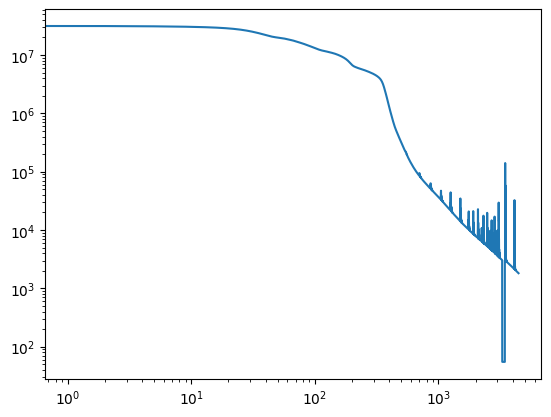

In [48]:
plt.loglog(loss_history)

### Predictions

In [49]:
u_th_map = u_th.reshape(Br.shape).detach().numpy()
u_ph_map = u_ph.reshape(Br.shape).detach().numpy()

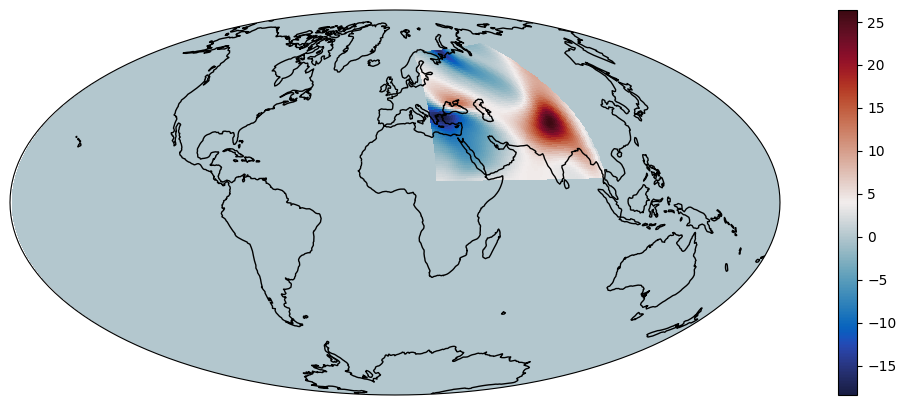

In [50]:
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

u_th_full = numpy.zeros((thetas.size, phis.size))
u_th_full[i1:i2,j1:j2] = u_th_map

thetas_bis_deg = numpy.rad2deg(thetas)
phis_bis_deg = numpy.rad2deg(phis)

latitudes = pygeo.convertThetasToLatitudes(thetas)
longitudes = pygeo.convertPhisToLongitudes(phis)

lat_grid, lon_grid = numpy.meshgrid(latitudes, longitudes, indexing="ij")

fig = plt.figure(figsize=(15,5))

# Set the projection to Hammer and add the axes
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Aitoff())

# Use `pcolormesh` to project the data onto the map
pcol = ax.pcolormesh(lon_grid, lat_grid, u_th_full, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance)

# Add coastlines for context
ax.coastlines()

plt.colorbar(pcol)